## IBM Data Science Professional Certificate<br>Applied Data Science  |  Capstone project
# Car accident severity
### Isabel Almeida<br>September 2020

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Introduction

### Business Problem / Business Understanding

Vehicle collisions can be costly not just to those involved, but to society as a whole. Besides financial expenditures, costs to individuals and families can be considerable, especially in cases with severe injuries or fatalities. With hundreds of thousands of vehicle collisions registered annually, it is important to analyze the conditions under which they occur so that the public and policy makers can take action.

To help with such understanding, by using machine learning techniques this study attempts to predict the severity of vehicle collisions in the city of Seattle based on observable conditions. In this way, both individuals and traffic monitors can become more alert when relevant conditions are present and take preventative measures to avoid further accidents.

# 2. Data

The example dataset of collisions in Seattle city, provided in Week 1 of the Capstone Project syllabus, will be used in this project.

### Data understanding / Data preparation

The metadata for the Seattle collision dataset can be found [here](https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Metadata.pdf).<br>
Let's have a first look at the dataset.

In [2]:
pd.set_option('display.max_columns', None)

df = pd.read_csv('Data-Collisions.csv',
                 # "INCDTTM" was formatted as datetime after further analysis in the next sections.
                 parse_dates = ['INCDTTM'])
df

/opt/miniconda3/envs/ds376/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,EXCEPTRSNCODE,EXCEPTRSNDESC,SEVERITYCODE.1,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INCDATE,INCDTTM,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,5TH AVE NE AND NE 103RD ST,,NaN,2,Injury Collision,Angles,2,0,0,2,2013/03/27 00:00:00+00,2013-03-27 14:54:00,At Intersection (intersection related),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,N,Overcast,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,AURORA BR BETWEEN RAYE ST AND BRIDGE WAY N,NaN,NaN,1,Property Damage Only Collision,Sideswipe,2,0,0,2,2006/12/20 00:00:00+00,2006-12-20 18:55:00,Mid-Block (not related to intersection),16,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE ...",NaN,0,Raining,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,4TH AVE BETWEEN SENECA ST AND UNIVERSITY ST,NaN,NaN,1,Property Damage Only Collision,Parked Car,4,0,0,3,2004/11/18 00:00:00+00,2004-11-18 10:20:00,Mid-Block (not related to intersection),14,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",NaN,0,Overcast,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,2ND AVE BETWEEN MARION ST AND MADISON ST,,NaN,1,Property Damage Only Collision,Other,3,0,0,3,2013/03/29 00:00:00+00,2013-03-29 09:26:00,Mid-Block (not related to intersection),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,N,Clear,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,SWIFT AVE S AND SWIFT AV OFF RP,NaN,NaN,2,Injury Collision,Angles,2,0,0,2,2004/01/28 00:00:00+00,2004-01-28 08:04:00,At Intersection (intersection related),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,0,Raining,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194668,2,-122.290826,47.565408,219543,309534,310814,E871089,Matched,Block,NaN,34TH AVE S BETWEEN S DAKOTA ST AND S GENESEE ST,,NaN,2,Injury Collision,Head On,3,0,0,2,2018/11/12 00:00:00+00,2018-11-12 08:12:00,Mid-Block (not related to intersection),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,N,Clear,Dry,Daylight,NaN,NaN,NaN,24,From opposite direction - both moving - head-on,0,0,N
194669,1,-122.344526,47.690924,219544,309085,310365,E876731,Matched,Block,NaN,AURORA AVE N BETWEEN N 85TH ST AND N 86TH ST,,NaN,1,Property Damage Only Collision,Rear Ended,2,0,0,2,2018/12/18 00:00:00+00,2018-12-18 09:14:00,Mid-Block (not related to intersection),14,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",Y,N,Raining,Wet,Daylight,NaN,NaN,NaN,13,From same direction - both going straight - bo...,0,0,N
194670,2,-122.306689,47.683047,219545,311280,312640,3809984,Matched,Intersection,24760.0,20TH AVE NE AND NE 75TH ST,,NaN,2,Injury Collision,Left Turn,3,0,0,2,2019/01/19 00:00:00+00,2019-01-19 09:25:00,At Intersection (intersection related),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,N,Clear,Dry,Daylight,NaN,NaN,NaN,28,From opposite direction - one left turn - one ...,0,0,N
194671,2,-122.355317,47.678734,219546,309514,310794,3810083,Matched,Intersection,24349.0,GREENWOOD AVE N AND N 68TH ST,,NaN,2,Injury Collision,Cycles,2,0,1,1,2019/01/15 00:00:00+00,2019-01-15 16:48:00,At Intersection (intersection related),51,PEDALCYCLIST STRUCK MOTOR VEHICLE FRONT END AT...,NaN,N,Clear,Dry,Dusk,NaN,NaN,NaN,5,Vehicle Strikes Pedalcyclist,4308,0,

The dataset contains 194,673 collision records with 38 attributes.<br>
<br>
Because the objective of this project is to guess the severity of a crash based on other available data, we know immediately that our target variable (dependent feature) is "SEVERITYCODE". According to the metadata documentation, it is a categorical variable with 5 possible values. We will check the actual range of values for "SEVERITYCODE" in this dataset in the sections ahead.<br>
<br>
Because our dependent feature is categorical, that is, it can only assume one of a discrete number of classes, we already know our project will be featuring a classification machine learning model.<br>
<br>
A quick look at the table makes it clear that the data in the example dataset and the dataset referenced in the metadata documentation are slightly different: some of the columns exist in one, but not in the other, and vice-versa.<br>
Columns without a corresponding description in the metadata documentation and an unclear purpose will be deleted, as there is no way to check exactly what information they hold. Columns with seemingly irrelevant or redundant information will also be deleted.<br>
<br>
When isolating the time (HH:MM:SS) from the datetime column "INCDTTM" and checking its unique value counts, 16% of collisions are recorded as having occurred at exactly 00:00:00. This is likely a workaround for collisions where the time of the event is unknown, and such records will be replaced by 999:00:00, which will serve as the numeric equivalent to "Unspecified".<br>
<br>
Moreover, the "INCDTTM" column contains date and time information for each collision. Because we only wish to use bits of this information in our model, it will be split and replaced by three attributes: "Month", "Weekday" and "Hour".<br>
<br>
Finally, it would be interesting to map the X and Y coordinates to Seattle's neighbourhoods to check for patterns, but because of restrictions on the number of requests that can be made to the respective geocoding library API (1 per second), it won't be done in this study.

In [3]:
# Replacing 00:00:00 timestamps with 999:00:00:
df['hour_hms'] = df['INCDTTM'].dt.strftime('%X')
df['hour_hms'].replace({'00:00:00': '999:00:00'}, inplace=True)

# Splitting the "INCDTTM" column into additional attributes for the model:
df['Month'] = df['INCDTTM'].dt.month
df['Weekday'] = df['INCDTTM'].dt.dayofweek
hour_split = df['hour_hms'].str.split(":",n=1,expand=True)
df['Hour'] = hour_split[0]
df['Hour'] = pd.to_numeric(df['Hour'], errors='coerce')

df = df.drop(
    # Datetime columns replaced by the three attributes above:
    ['INCDTTM', 'hour_hms',
    
    # Columns with no corresponding description in metadata documentation and purpose is unclear: 
    "REPORTNO", "STATUS", "EXCEPTRSNCODE", "EXCEPTRSNDESC",
     
    # Dropping coordinates:
    "X","Y",
     
    # Columns with seemingly irrelevant or redundant information:
    "OBJECTID", "INCKEY", "COLDETKEY", "INTKEY", "LOCATION", "SEVERITYCODE.1", "SEVERITYDESC", "INCDATE", 
    "SDOT_COLDESC", "SDOTCOLNUM", "ST_COLDESC", "SEGLANEKEY", "CROSSWALKKEY",
    
    # Column dropped due to insufficient metadata documentation, seen in further analysis in the next sections:
     "UNDERINFL"],
    
    axis=1)

# Turning all numbers stored as strings in "ST_COLCODE" into numeric data type:
df['ST_COLCODE'] = pd.to_numeric(df['ST_COLCODE'], errors='coerce')

# Categorical columns where NaN will be replaced by "Unknown", seen in further analysis in the next sections:
cols1=['ADDRTYPE','COLLISIONTYPE','JUNCTIONTYPE','WEATHER','ROADCOND','LIGHTCOND']
df[cols1] = df[cols1].fillna('Unknown')

# Categorical columns where NaN will be replaced by "N", seen in further analysis in the next sections:
cols2=['INATTENTIONIND','PEDROWNOTGRNT','SPEEDING']
df[cols2] = df[cols2].fillna('N')

# Coordinate columns where NaN will be replaced by 999, seen in further analysis in the next sections:
cols3=['ST_COLCODE']
df[cols3] = df[cols3].fillna(999)

df

,SEVERITYCODE,ADDRTYPE,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,JUNCTIONTYPE,SDOT_COLCODE,INATTENTIONIND,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SPEEDING,ST_COLCODE,HITPARKEDCAR,Month,Weekday,Hour
0,2,Intersection,Angles,2,0,0,2,At Intersection (intersection related),11,N,Overcast,Wet,Daylight,N,N,10.0,N,3,2,14
1,1,Block,Sideswipe,2,0,0,2,Mid-Block (not related to intersection),16,N,Raining,Wet,Dark - Street Lights On,N,N,11.0,N,12,2,18
2,1,Block,Parked Car,4,0,0,3,Mid-Block (not related to intersection),14,N,Overcast,Dry,Daylight,N,N,32.0,N,11,3,10
3,1,Block,Other,3,0,0,3,Mid-Block (not related to intersection),11,N,Clear,Dry,Daylight,N,N,23.0,N,3,4,9
4,2,Intersection,Angles,2,0,0,2,At Intersection (intersection related),11,N,Raining,Wet,Daylight,N,N,10.0,N,1,2,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194668,2,Block,Head On,3,0,0,2,Mid-Block (not related to intersection),11,N,Clear,Dry,Daylight,N,N,24.0,N,11,0,8
194669,1,Block,Rear Ended,2,0,0,2,Mid-Block (not related to intersection),14,Y,Raining,Wet,Daylight,N,N,13.0,N,12,1,9
194670,2,Intersection,Left Turn,3,0,0,2,At Intersection (intersection related),11,N,Clear,Dry,Daylight,N,N,28.0,N,1,5,9
194671,2,Intersection,Cycles,2,0,1,1,At Intersection (intersection related),51,N,Clear,Dry,Dusk,N,N,5.0,N,1,1,16


The same 194,673 records remain but now we are only working with 20 attributes.<br>
<br>
Let's have a look at the unique values in each of the remaining columns.

In [4]:
for column in df.columns:
     print("Name: ",column,"\n",
           "Data type: ",df[column].dtype,"\n\n",
           "Value count:","\n",
           df[column].value_counts(dropna=False),"\n\n",
           "Value frequency:","\n",
           df[column].value_counts(dropna=False, normalize=True),"\n\n\n",)

Name:  SEVERITYCODE 
 Data type:  int64 

 Value count: 
 1    136485
2     58188
Name: SEVERITYCODE, dtype: int64 

 Value frequency: 
 1    0.701099
2    0.298901
Name: SEVERITYCODE, dtype: float64 



Name:  ADDRTYPE 
 Data type:  object 

 Value count: 
 Block           126926
Intersection     65070
Unknown           1926
Alley              751
Name: ADDRTYPE, dtype: int64 

 Value frequency: 
 Block           0.651996
Intersection    0.334253
Unknown         0.009894
Alley           0.003858
Name: ADDRTYPE, dtype: float64 



Name:  COLLISIONTYPE 
 Data type:  object 

 Value count: 
 Parked Car    47987
Angles        34674
Rear Ended    34090
Other         23703
Sideswipe     18609
Left Turn     13703
Pedestrian     6608
Cycles         5415
Unknown        4904
Right Turn     2956
Head On        2024
Name: COLLISIONTYPE, dtype: int64 

 Value frequency: 
 Parked Car    0.246501
Angles        0.178114
Rear Ended    0.175114
Other         0.121758
Sideswipe     0.095591
Left Turn   

Name:  SPEEDING 
 Data type:  object 

 Value count: 
 N    185340
Y      9333
Name: SPEEDING, dtype: int64 

 Value frequency: 
 N    0.952058
Y    0.047942
Name: SPEEDING, dtype: float64 



Name:  ST_COLCODE 
 Data type:  float64 

 Value count: 
 32.0    44421
10.0    34674
14.0    25771
50.0    13554
11.0    12777
        ...  
43.0        2
87.0        2
60.0        1
85.0        1
49.0        1
Name: ST_COLCODE, Length: 63, dtype: int64 

 Value frequency: 
 32.0    0.228183
10.0    0.178114
14.0    0.132381
50.0    0.069624
11.0    0.065633
          ...   
43.0    0.000010
87.0    0.000010
60.0    0.000005
85.0    0.000005
49.0    0.000005
Name: ST_COLCODE, Length: 63, dtype: float64 



Name:  HITPARKEDCAR 
 Data type:  object 

 Value count: 
 N    187457
Y      7216
Name: HITPARKEDCAR, dtype: int64 

 Value frequency: 
 N    0.962933
Y    0.037067
Name: HITPARKEDCAR, dtype: float64 



Name:  Month 
 Data type:  int64 

 Value count: 
 10    17768
5     16763
11    16582
6 

The attribute "UNDERINFL", which is meant to be a categorical Y/N variable, shows additional "0" and "1" values with no corresponding explanation in the metadata documentation. To avoid misinterpretations, this column will also be dropped from our dataset (code in previous cells adjusted).<br>
<br>
All data types seem to match except for "ST_COLCODE", meant to be purely numeric as it refers to a code, but shown as an object type. The column will be converted to integer (code in previous cells adjusted).<br>
<br>
We also have a number of NaN values. For categorical attributes, they will be replaced by "Unknown" or "No" according to the nature of the information in a given column. NaN values in "ST_COLCODE"'s will be replaced by 999, which is out of the collision code range (code in previous cells adjusted).<br>
<br>
Although the metadata describes 5 possible values for "SEVERITYCODE", this dataset contains only 2, meaning our target variable is binary. This may affect the choice of algorithm to complete this project, which will be discussed in the appropriate section further ahead.

# 3. Methodology

### Exploratory Data Analysis

Let's plot some of the columns to visualize the data.

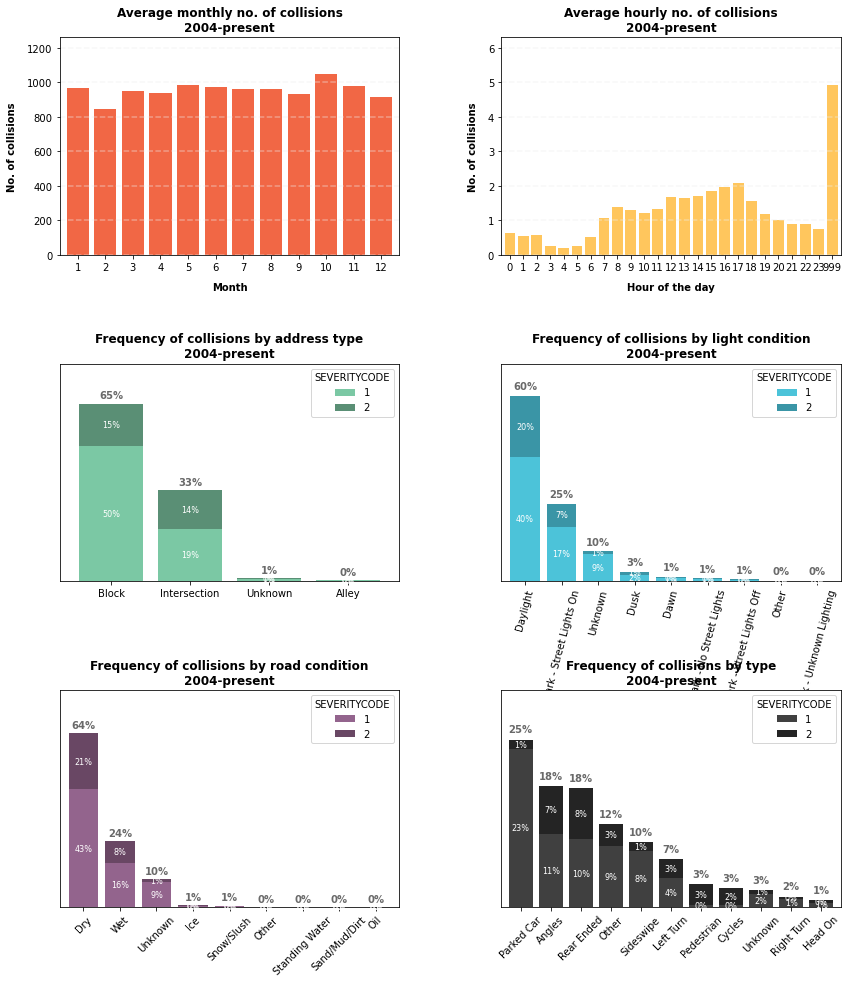

In [5]:
fig = plt.figure(figsize=(14,16))

# Average monthly no. of collisions in Seattle --------------------------------------------------------------
ax1 = fig.add_subplot(3,2,1)
plot_df = df.groupby(df['Month'])['SEVERITYCODE'].agg(['count']).div(2020-2003)
plot_df.plot(ax=ax1, kind='bar', color='#F16745', width=0.8, rot=0, legend=False)
ax1.set_xlabel('Month', weight='bold', labelpad=10)
ax1.set_ylabel('No. of collisions', weight='bold', labelpad=10)
ax1.set_title('Average monthly no. of collisions\n2004-present', weight='bold', size=12)
# Drawing lines for the y ticks:
vals = ax1.get_yticks()
for tick in vals:
    ax1.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)
    
# Average hourly no. of collisions in Seattle ---------------------------------------------------------------
ax2 = fig.add_subplot(3,2,2)
plot_df = df.groupby(df['Hour'])['SEVERITYCODE'].agg(['count']).div((2020-2003)*365)
plot_df.plot(ax=ax2, kind='bar', color='#FFC65D', rot=0, width=0.8, legend=False)
ax2.set_xlabel('Hour of the day', weight='bold', labelpad=10)
ax2.set_ylabel('No. of collisions', weight='bold', labelpad=10)
ax2.set_title('Average hourly no. of collisions\n2004-present', weight='bold', size=12)
vals = ax2.get_yticks()
for tick in vals:
    ax2.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

# Address type ----------------------------------------------------------------------------------------------
pivot = df.pivot_table(index='ADDRTYPE', columns='SEVERITYCODE',aggfunc='size')/len(df['SEVERITYCODE'])
pivot['Total']=pivot[1]+pivot[2]
pivot = pivot.sort_values(['Total'], ascending=False)
pivot = pivot.drop(['Total'], axis=1)

ax3 = fig.add_subplot(3,2,3)
pivot.plot(ax=ax3, kind='bar', stacked=True, width=0.8, color=["#7BC8A4", "#5a8f75"], rot=0)

# Prettifying the chart.
ax3.set_xlabel('')
ax3.set_ylim(0,0.8)
ax3.axes.yaxis.set_ticks([])
ax3.set_title('Frequency of collisions by address type\n2004-present', weight='bold', size=12)

# Labeling each stack + total for each bar.
# This loop only works for stacked charts with two stacks (in this case, severity 1 and 2).       
for p in ax3.patches:
    if ax3.patches.index(p) <= (pivot.shape[0]-1):
        cumulative_height = p.get_height()
    else:
        cumulative_height = p.get_height() + ax3.patches[(ax3.patches.index(p))-pivot.shape[0]].get_height()
    
    width, height = p.get_width(), p.get_height()
    
    ax3.annotate('{:.0f}%'.format(height*100), (p.get_x()+(width/2), cumulative_height-(height/2)), 
                horizontalalignment='center', verticalalignment='center',
                fontsize=8, color='white')
    
    if (cumulative_height-height) != 0:
        ax3.annotate('{:.0f}%'.format(cumulative_height*100), (p.get_x()+(width/2), cumulative_height+.03), 
                horizontalalignment='center', verticalalignment='center',
                fontsize=10, weight='bold',color='dimgrey')
    
# Light conditions -----------------------------------------------------------------------------------------
pivot = df.pivot_table(index='LIGHTCOND', columns='SEVERITYCODE',aggfunc='size')/len(df['SEVERITYCODE'])
pivot['Total']=pivot[1]+pivot[2]
pivot = pivot.sort_values(['Total'], ascending=False)
pivot = pivot.drop(['Total'], axis=1)

ax4 = fig.add_subplot(3,2,4)
pivot.plot(ax=ax4, kind='bar', stacked=True, width=0.8, color=["#4CC3D9", "#3a95a6"], rot=75)

ax4.set_xlabel('')
ax4.set_ylim(0,0.7)
ax4.axes.yaxis.set_ticks([])
ax4.set_title('Frequency of collisions by light condition\n2004-present', weight='bold', size=12)

for p in ax4.patches:
    if ax4.patches.index(p) <= (pivot.shape[0]-1):
        cumulative_height = p.get_height()
    else:
        cumulative_height = p.get_height() + ax4.patches[(ax4.patches.index(p))-pivot.shape[0]].get_height()
    
    width, height = p.get_width(), p.get_height()
    
    ax4.annotate('{:.0f}%'.format(height*100), (p.get_x()+(width/2), cumulative_height-(height/2)), 
                horizontalalignment='center', verticalalignment='center',
                fontsize=8, color='white')
    
    if (cumulative_height-height) != 0:
        ax4.annotate('{:.0f}%'.format(cumulative_height*100), (p.get_x()+(width/2), cumulative_height+.03), 
                horizontalalignment='center', verticalalignment='center',
                fontsize=10, weight='bold',color='dimgrey')
    
# Road conditions ------------------------------------------------------------------------------------------
pivot = df.pivot_table(index='ROADCOND', columns='SEVERITYCODE',aggfunc='size')/len(df['SEVERITYCODE'])
pivot['Total']=pivot[1]+pivot[2]
pivot = pivot.sort_values(['Total'], ascending=False)
pivot = pivot.drop(['Total'], axis=1)

ax5 = fig.add_subplot(3,2,5)
pivot.plot(ax=ax5, kind='bar', stacked=True, width=0.8, color=["#93648D", "#694764"], rot=45)

ax5.set_xlabel('')
ax5.set_ylim(0,0.8)
ax5.axes.yaxis.set_ticks([])
ax5.set_title('Frequency of collisions by road condition\n2004-present', weight='bold', size=12)

for p in ax5.patches:
    if ax5.patches.index(p) <= (pivot.shape[0]-1):
        cumulative_height = p.get_height()
    else:
        cumulative_height = p.get_height() + ax5.patches[(ax5.patches.index(p))-pivot.shape[0]].get_height()
    
    width, height = p.get_width(), p.get_height()
    
    ax5.annotate('{:.0f}%'.format(height*100), (p.get_x()+(width/2), cumulative_height-(height/2)), 
                horizontalalignment='center', verticalalignment='center',
                fontsize=8, color='white')
    
    if (cumulative_height-height) != 0:
        ax5.annotate('{:.0f}%'.format(cumulative_height*100), (p.get_x()+(width/2), cumulative_height+.03), 
                horizontalalignment='center', verticalalignment='center',
                fontsize=10, weight='bold',color='dimgrey')
    
# Collision type -------------------------------------------------------------------------------------------
pivot = df.pivot_table(index='COLLISIONTYPE', columns='SEVERITYCODE',aggfunc='size')/len(df['SEVERITYCODE'])
pivot['Total']=pivot[1]+pivot[2]
pivot = pivot.sort_values(['Total'], ascending=False)
pivot = pivot.drop(['Total'], axis=1)

ax6 = fig.add_subplot(3,2,6)
pivot.plot(ax=ax6, kind='bar', stacked=True, width=0.8, color=["#404040", "#242424"], rot=45)

ax6.set_xlabel('')
ax6.set_ylim(0,0.32)
ax6.axes.yaxis.set_ticks([])
ax6.set_title('Frequency of collisions by type\n2004-present', weight='bold', size=12)

for p in ax6.patches:
    if ax6.patches.index(p) <= (pivot.shape[0]-1):
        cumulative_height = p.get_height()
    else:
        cumulative_height = p.get_height() + ax6.patches[(ax6.patches.index(p))-pivot.shape[0]].get_height()
    
    width, height = p.get_width(), p.get_height()
    
    ax6.annotate('{:.0f}%'.format(height*100), (p.get_x()+(width/2), cumulative_height-(height/2)), 
                horizontalalignment='center', verticalalignment='center',
                fontsize=8, color='white')
    
    if (cumulative_height-height) != 0:
        ax6.annotate('{:.0f}%'.format(cumulative_height*100), (p.get_x()+(width/2), cumulative_height+.015), 
                horizontalalignment='center', verticalalignment='center',
                fontsize=10, weight='bold',color='dimgrey')
    
fig.subplots_adjust(wspace=0.3,hspace=0.5)

The average monthly number of collisions has a small valley in February and a small peak in October, but overall it stays in the range of 900-1000 collisions/month.<br>
<br>
When analyzed by hour of the day, on average the number of collisions starts to increase at 4:00 h, where not even 1 crash is reported, reaches intermediate peaks at 8:00 h and 12:00 h, and finally reaches a maximum peak at 17:00 h, where at least 2 crashes are reported. From 17:00 h onwards, the number of collisions steadily decrease to the 4:00 h low. This behaviour seems to correspond to the level of traffic activity during the day, which also tends to peak at rush and lunch hours. It may indicate that traffic volume is positively correlated to the incidence of traffic accidents. Daily, nearly 5 collisions are registered without an appropriate time estimate.<br>
<br>
In the next paragraphs we will look at the severity of a collision based on various conditions. According to the dataset metadata, SEVERITYCODE = 1 is an accident that caused only prop damage, while SEVERITYCODE = 2 is an accident that caused some level of injury.<br>
<br>
In regards to how the type of address affects the rate of collisions, most of the crashes happen at a block (65%), followed by intersections (33%) and alleys (<1%). An incident is almost twice as likely to happen at a block than at an intersection. However, crashes at intersections are almost twice as likely (14/33 = 42%) to provoke some kind of injury than at blocks (15/65 = 23%).<br>
<br>
Close to 60% of all crashes take place in daylight and about 25% in the dark, but with street lights on. This is consistent with the fact that most accidents occur in the morning and afternoon (second paragraph of this section). The rate of accidents with injury is very similar in both light conditions (20/60 = 33% for daylight and 7/25 = 28% for darkness with street lights).<br>
<br>
Roads are mostly dry in all registered incidents (64%), but it's not uncommon for them to be wet (24%). Roads covered in ice, snow, and other elements combined account for less than 2% of crash records. Collisions with injury are just as likely to happen in dry or wet roads (21/64 = 8/24 = 33%). <br>
<br>
Most of the collisions involve a parked car (25%), are at an angle (18%) or rear ended (18%). Other common types of collisions are sideswipes (10%) and left turns (7%). Although they happen more rarely, collisions involving pedestrians or cycles have a very high rate of injury (3/3 = 100% and 2/3 = 66%, respectively). Crashes at an angle, rear ended and left turns combined amass to 43% of all records, and each have a chance of injury of around 40% (7/18 = 39%, 8/18 = 44%, 3/7 = 43%).

### Model

Most of the attributes are categorical. To be able to run them into any chosen model, we will map them to quantitative variables.

In [6]:
cat_columns = df.select_dtypes(['object'])
encoding_maps = []

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for column in cat_columns:
    column_series = cat_columns[column]
    unique_values = column_series.unique()
    column_labels = le.fit_transform(column_series)
    column_mappings = {index: label for index, label in 
                  enumerate(le.classes_)}
    encoding_maps.append(column_mappings)
    df[column] = column_labels

print(*encoding_maps,sep = "\n\n")

{0: 'Alley', 1: 'Block', 2: 'Intersection', 3: 'Unknown'}

{0: 'Angles', 1: 'Cycles', 2: 'Head On', 3: 'Left Turn', 4: 'Other', 5: 'Parked Car', 6: 'Pedestrian', 7: 'Rear Ended', 8: 'Right Turn', 9: 'Sideswipe', 10: 'Unknown'}

{0: 'At Intersection (but not related to intersection)', 1: 'At Intersection (intersection related)', 2: 'Driveway Junction', 3: 'Mid-Block (but intersection related)', 4: 'Mid-Block (not related to intersection)', 5: 'Ramp Junction', 6: 'Unknown'}

{0: 'N', 1: 'Y'}

{0: 'Blowing Sand/Dirt', 1: 'Clear', 2: 'Fog/Smog/Smoke', 3: 'Other', 4: 'Overcast', 5: 'Partly Cloudy', 6: 'Raining', 7: 'Severe Crosswind', 8: 'Sleet/Hail/Freezing Rain', 9: 'Snowing', 10: 'Unknown'}

{0: 'Dry', 1: 'Ice', 2: 'Oil', 3: 'Other', 4: 'Sand/Mud/Dirt', 5: 'Snow/Slush', 6: 'Standing Water', 7: 'Unknown', 8: 'Wet'}

{0: 'Dark - No Street Lights', 1: 'Dark - Street Lights Off', 2: 'Dark - Street Lights On', 3: 'Dark - Unknown Lighting', 4: 'Dawn', 5: 'Daylight', 6: 'Dusk', 7: 'Other', 8: '

In [7]:
df

,SEVERITYCODE,ADDRTYPE,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,JUNCTIONTYPE,SDOT_COLCODE,INATTENTIONIND,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SPEEDING,ST_COLCODE,HITPARKEDCAR,Month,Weekday,Hour
0,2,2,0,2,0,0,2,1,11,0,4,8,5,0,0,10.0,0,3,2,14
1,1,1,9,2,0,0,2,4,16,0,6,8,2,0,0,11.0,0,12,2,18
2,1,1,5,4,0,0,3,4,14,0,4,0,5,0,0,32.0,0,11,3,10
3,1,1,4,3,0,0,3,4,11,0,1,0,5,0,0,23.0,0,3,4,9
4,2,2,0,2,0,0,2,1,11,0,6,8,5,0,0,10.0,0,1,2,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194668,2,1,2,3,0,0,2,4,11,0,1,0,5,0,0,24.0,0,11,0,8
194669,1,1,7,2,0,0,2,4,14,1,6,8,5,0,0,13.0,0,12,1,9
194670,2,2,3,3,0,0,2,1,11,0,1,0,5,0,0,28.0,0,1,5,9
194671,2,2,1,2,0,1,1,1,51,0,1,0,6,0,0,5.0,0,1,1,16


Although we are working exclusively with numbers now, it's important to consider that for many attributes they are merely representations of categorical variables and should not be interpreted as having intensity among their values (i.e. ADDRTYPE 0, Alley, is not less than ADDRTYPE 1, Block. They are simply different categories of adresses).<br>
<br>
For this reason, and referencing section 2. Data, where we established that because our dependent feature SEVERITYCODE is categorical our model will be a classifier, the Decision Tree algorithm was chosen for predicting accident severity in this dataset. The Decision Tree splits its branches iteratively by each attribute's unique records, a behaviour  that fits nicely with the categorical features' defined values.<br>
<br>
By choosing the Decision Tree classifier we will also avoid having to one-hot encode the categorical columns of the dataset, which would increase its dimensions and potentially affect the model's ability to make good predictions.<br>
<br>
Now, let's define our model's feature set X and target variable y and split the data into train and test sets. We will use a 80:20 ratio of the dataset to train and test the model.

In [8]:
# Defining feature matrix X and target variable y (SEVERITYCODE):
X = df.iloc[:,1:22].values
y = df['SEVERITYCODE'].values

from sklearn.model_selection import train_test_split

# Splitting the dataset:
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.2, random_state=3)

When looking at the count of "SEVERITYCODE" records in our training set (y_trainset), we notice that 70% (95,638/194,673) of values belong to category 1 and 30% (40,633/194,673) to category 2. It is therefore unbalanced, which introduces a bias in our model in favour of the most frequent category (1).

In [9]:
np.array(np.unique(y_trainset, return_counts=True)).T

array([[     1, 109260],
       [     2,  46478]])

Because our minority class still shows a comfortably large number of rows, to treat this imbalance the training set's category 1 values will be undersampled.

In [10]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy='majority')
X_trainset, y_trainset = rus.fit_resample(X_trainset, y_trainset)

print(X_trainset.shape)
print(y_trainset.shape)

(92956, 19)
(92956,)


In [11]:
np.array(np.unique(y_trainset, return_counts=True)).T

array([[    1, 46478],
       [    2, 46478]])

As we can see, our total training set has been reduced to 92,956 records due to the random deletion of category 1 rows (majority class) to match the exact count of category 2 rows (minority class). Our training set is now balanced, with 50% of records belonging to each dependent feature class.<br>
<br>
We are now ready to build our decision tree. For the splitting criteria, we are going to use entropy (information gain). As for the number of times we are going to split the tree (max_depth), we are going to test a range of values to see which yields the best model performance:

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

depth_scores = pd.DataFrame(index=['Accuracy','Precision','Recall','F1 Score'])

for i in range(1,21):
    severity_tree = DecisionTreeClassifier(criterion="entropy", max_depth=i)
    severity_tree.fit(X_trainset,y_trainset)
    pred_tree = severity_tree.predict(X_testset)
    
    depth_scores[i] = [accuracy_score(y_testset,pred_tree),precision_score(y_testset,pred_tree),
                       recall_score(y_testset,pred_tree),f1_score(y_testset,pred_tree)]
    
depth_scores.style.format("{:.0%}")#.plot.line(figsize=(12,16))

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Accuracy,55%,51%,64%,64%,68%,66%,68%,68%,69%,69%,68%,68%,68%,68%,68%,68%,67%,67%,67%,66%
Precision,84%,95%,88%,89%,86%,89%,88%,88%,88%,88%,88%,88%,88%,88%,87%,87%,86%,86%,85%,85%
Recall,44%,31%,56%,56%,64%,59%,63%,63%,65%,63%,63%,63%,63%,63%,63%,64%,63%,63%,63%,63%
F1 Score,58%,47%,68%,68%,74%,71%,74%,73%,75%,74%,74%,73%,73%,73%,73%,73%,73%,72%,73%,72%


The model performs best when max_depth = 9, where both accuracy and F1 score are the highest in the range at 69% and 75% respectively. The model's accuracy score could likely be improved with more sophisticated feature engineering (i.e. reducing the number of features to a few with the most impact on collision severity), but for the purposes of this study we will consider a score of 69% satisfactory.

# 4. Results & Discussion

Let's establish our decision tree at max_depth = 9 and analyze its confusion matrix.

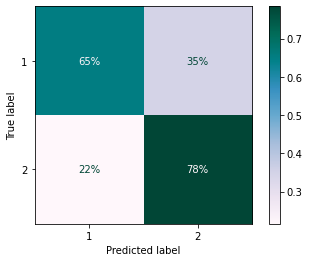

In [13]:
severity_tree = DecisionTreeClassifier(criterion="entropy", max_depth=9)
severity_tree.fit(X_trainset,y_trainset)
pred_tree = severity_tree.predict(X_testset)

from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(severity_tree,X_testset,y_testset,normalize='true',values_format=".0%",cmap='PuBuGn')
plt.show()

As we can see, although the overall model accuracy is 69%, it was able to correctly predict 78% instances of class 2, the most severe collision type. This means the model is fairly good at guessing when crashes involve injury, and its class 2 prognoses can be trusted with a good level of confidence. On the other hand, only about 2/3 of class 1 instances were correctly categorized as so, meaning the model's prop damage predictions are slightly less reliable.<br>
<br>
Let's plot our decision tree and see what insights we can draw from it.

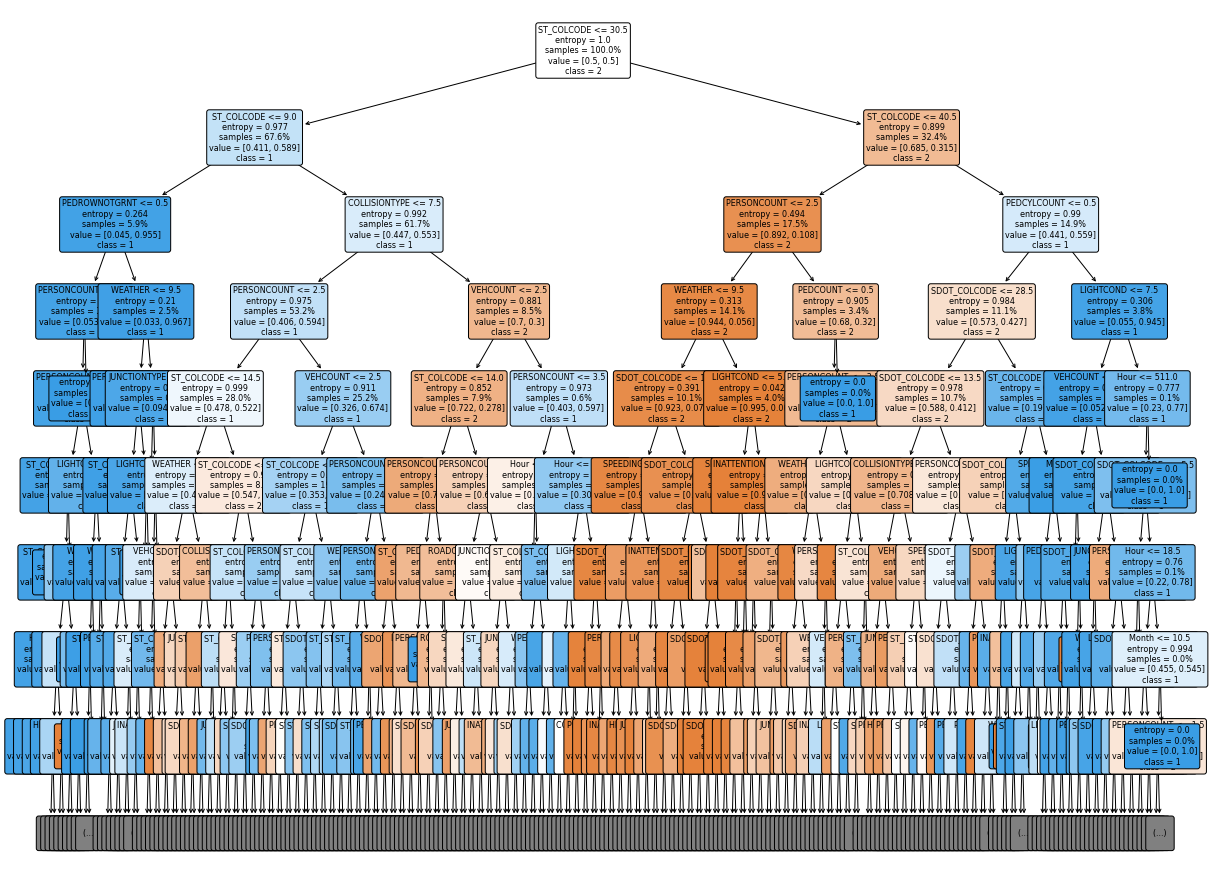

In [14]:
from sklearn import tree
plt.figure(figsize=(20,16))
_ = tree.plot_tree(severity_tree, max_depth=8, 
                   feature_names=df.iloc[:,1:22].columns, class_names=df.SEVERITYCODE.unique().astype(str),
                   proportion=True,
                   filled=True, fontsize=8, rounded=True)
plt.show()

The state collision code (ST_COLCODE) immediately appears as one of the most relevant factors for classifying collision severity (reminder: state collision codes are described in the dataset metadata, found [here](https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Metadata.pdf)). Crashes of code equal to or under 30 tend to be less severe, visually evidenced by the predominantly blue nodes (class 1) on the leftmost branch of the tree. Codes above 30 indicate a higher probability of more serious crashes (class 2), represented by the orange nodes that dominate the rightmost side of the tree.<br>
<br>
When the state collision code is 5 or less (there is no actual code 9), it is almost certain the accident caused only prop damage as the nodes become very pure towards class 1. Similarly, when the code is between 30 (non-inclusive) and 40, and up to 2 people are involved (PERSONCOUNT), it is almost certain the accident caused injury as the nodes become purer towards class 2. A similar analysis can be done for all paths in the tree.<br>
<br>
The other tree branches show varying levels of impurity, but attributes that seem to help increase node purity and thus are more relevant indicators of collision severity are: type of collision (COLLISIONTYPE), number of vehicles involved in the accident (VEHCOUNT), number of bicycles involved in the accident (PEDCYLCOUNT), and number of pedestrians involved in the accident (PEDCOUNT).<br>
<br>
A text summary of the tree's classification rules is provided below.

In [15]:
from sklearn.tree import export_text
r = export_text(severity_tree, feature_names=df.iloc[:,1:22].columns.tolist())
print(r)

|--- ST_COLCODE <= 30.50
|   |--- ST_COLCODE <= 9.00
|   |   |--- PEDROWNOTGRNT <= 0.50
|   |   |   |--- PERSONCOUNT <= 5.50
|   |   |   |   |--- PERSONCOUNT <= 4.50
|   |   |   |   |   |--- ST_COLCODE <= 6.50
|   |   |   |   |   |   |--- ST_COLCODE <= 3.50
|   |   |   |   |   |   |   |--- Hour <= 14.50
|   |   |   |   |   |   |   |   |--- Month <= 2.50
|   |   |   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |   |   |   |--- Month >  2.50
|   |   |   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |   |   |--- Hour >  14.50
|   |   |   |   |   |   |   |   |--- Weekday <= 5.50
|   |   |   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |   |   |   |--- Weekday >  5.50
|   |   |   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |   |--- ST_COLCODE >  3.50
|   |   |   |   |   |   |   |--- Hour <= 15.50
|   |   |   |   |   |   |   |   |--- Weekday <= 0.50
|   |   |   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |   |   |   |--- Weekd

# 5. Conclusion

In this study we have built a decision tree to predict the severity of car accidents in the city of Seattle. As a supervised model, it was able to successfully guess the severity of 69% of historical records based on 19 attributes, being particularly good at predicting accidents with injury.<br>
<br>
Among the attributes utilized in the model, state collision code (ST_COLCODE), number of people involved in the accident (PERSONCOUNT), type of collision (COLLISIONTYPE), number of vehicles involved in the accident (VEHCOUNT), number of bicycles involved in the accident (PEDCYLCOUNT) and the number of pedestrians involved in the accident (PEDCOUNT) were identified as the best predictors of collision severity.<br>
<br>
Having identified these variables, policy makers can implement measures such as redesigning traffic flow to reduce the incidence of more severe types of collisions (based on ST_COLCODE > 30, for example), expanding bicycle paths (to reduce PEDCYLCOUNT), installing safety devices to better delimit vehicle and pedestrian spaces (to reduce PEDCOUNT), etc. The general public, in turn, should be informed of the conditions that favour accidents, especially more severe ones, and attempt to circulate the city (drivers, bikers and pedestrians alike) in a way as to avoid such conditions.